In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('./data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

C:\Users\HamIG\AppData\Local\Temp\ipykernel_69808\3661478533.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 데이터 불러오기

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [3]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [4]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [5]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


### 그래프 그리기

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

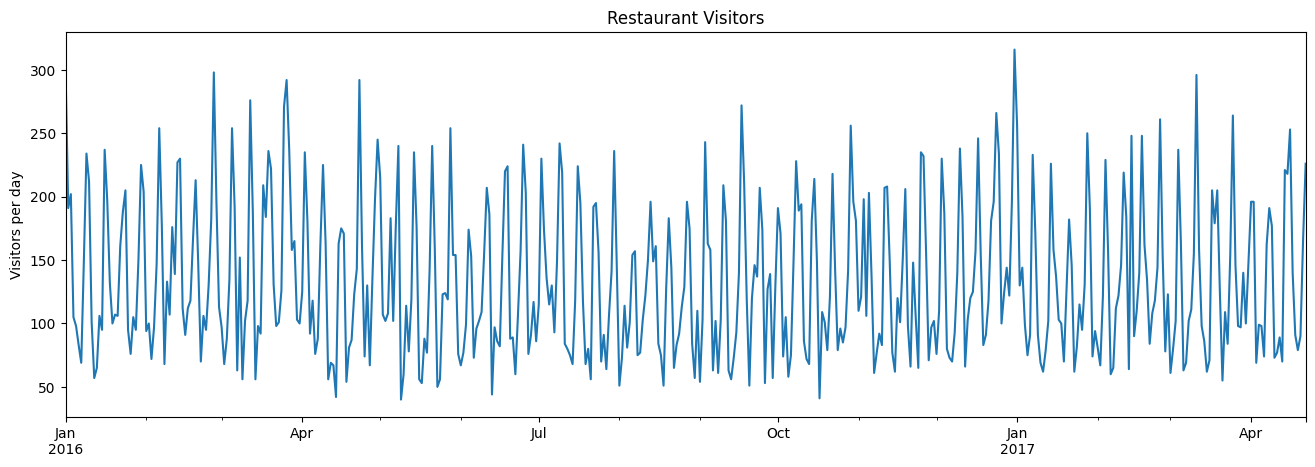

In [6]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

주마다 꼭지점이 생김. 

### 휴일선 그리기 

In [8]:
# Statsmodels를 사용 시, 이 메소드를 쓸 것. 

df1.query('holiday==1').index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

In [9]:
df1[df1['holiday']==1].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

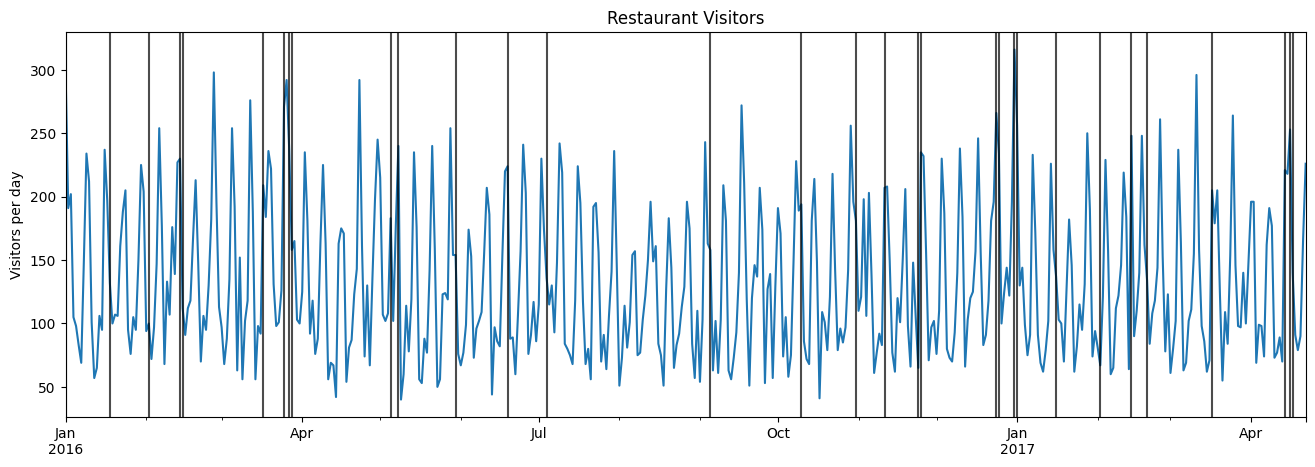

In [13]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       
    ax.axvline(x=x, color='black', alpha = 0.7);  

1월 시작 전후로 휴일 선이 겹치는 모습을 확인할 수 있음. 휴일과 겹치는 꼭지점을 발견하기 어렵다. 

### ETS 분해 

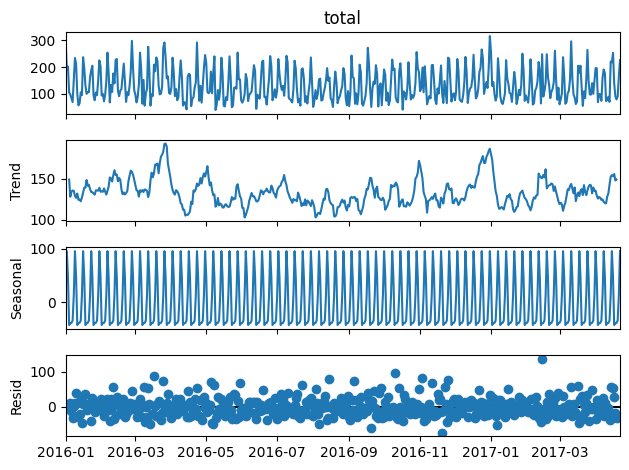

In [14]:
result = seasonal_decompose(df1['total'])
result.plot();

<Axes: xlabel='date'>

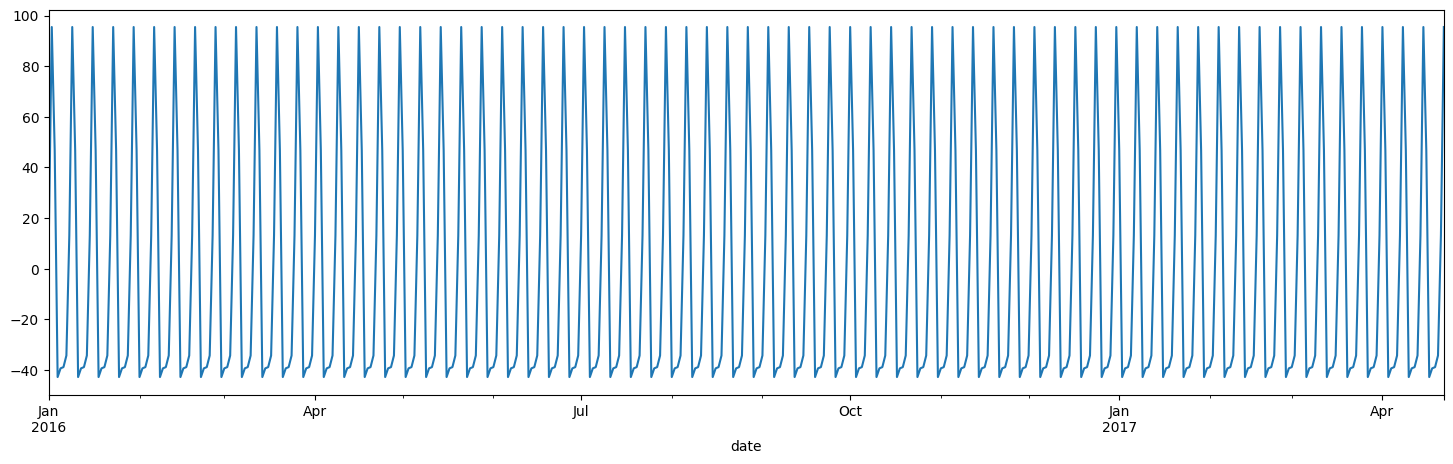

In [15]:
result.seasonal.plot(figsize=(18,5))

3번째 그래프가 계절성을 의미함. 계절성이 강한 모습을 확인할 수 있다.\
한 달마다 4개의 계절성 기간이 있다? -> 7일씩 4주 얘기하는듯\
주말과 주중 계절성이 있을 것으로 판단됨. 따라서, 여기서는 주를 계절성으로 판단함. 

### SARIMA 모델 적합

In [16]:
len(df1)

478

In [17]:
train = df1.iloc[:436]

In [18]:
test = df1.iloc[436:]

In [19]:
from pmdarima import auto_arima

In [56]:
# 차수 결정을 위해 전체 데이터를 넣음. 
# 차수 결정에는 가능한 많은 정보를 담는 것이 합리적이기 때문

auto_arima(df1['total'], seasonal=True, m=7).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.422
Date:                   Tue, 09 Apr 2024   AIC                           4766.843
Time:                           02:00:03   BIC                           4783.521
Sample:                       01-01-2016   HQIC                          4773.400
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4151      1.404      2.433      0.015       0.663       6.167
ar.S.L7        0.9723      0.011     88.860      0.000       0.951       0.994
ma.S.L7       -0.7874      0.047    -16.821      0.000      -0.879      -0.696
sigma2      1216.0815     71.884     16.917      0.000    1075.192    1356.971
===================================================================================
Ljung-Box (L1) (Q):                  15.43   Jarque-Bera (JB):                72.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

이 모델인 SARIMAX(1, 0, [1], 7)
-> ARIMA(1, 0, 1), SARIMA(1, 0, 1,7) 인듯? 


### 모델 적합

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [65]:
# 가역성을 강제로 유지할 것인지는 enforce_invertibility 옵션으로 
# 가역성을 준수하지 않아도 모델을 적합시킬 수 있도록 False를 사용

model = SARIMAX(train['total'], order = (1, 0, 1), seasonal_order=(1, 0, 1, 7), 
                enforce_invertibility=False)

In [66]:
results = model.fit()

In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2148.264
Date:                           Tue, 09 Apr 2024   AIC                           4306.529
Time:                                   02:03:57   BIC                           4326.917
Sample:                               01-01-2016   HQIC                          4314.575
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8366      0.069     12.144      0.000       0.702       0.972
ma.L1         -0.6665      0.094     -7.102      0.000      -0.850      -0.483
ar.S.L7        0.9998      0.000   4918.136      0.000       0.999       1.000
ma.S.L7       -0.9498      0.024    -39.881      0.000      -0.996      -0.903
sigma2      1042.0889     52.281     19.933      0.000     939.620    1144.557
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               105.50
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.77
Prob(H) (two-sided):                  0.71   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
start = len(train)
end = len(train) + len(test) - 1

In [69]:
predictions = results.predict(start, end).rename('SARIMA Model')

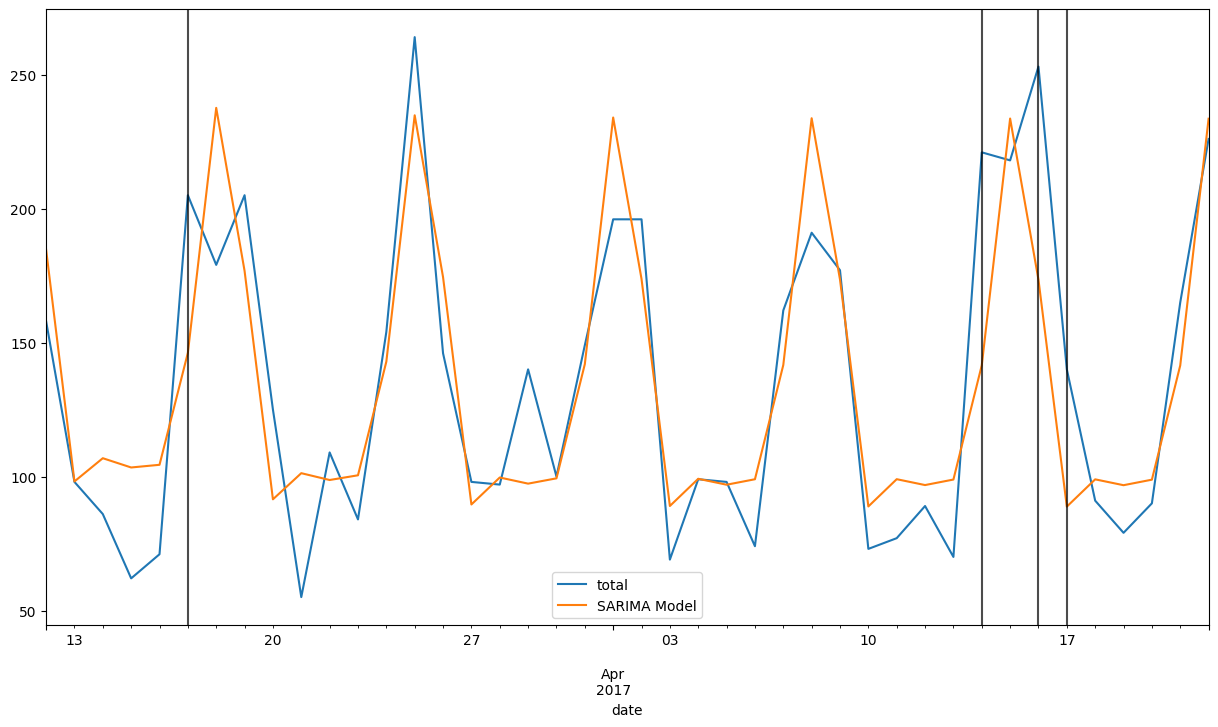

In [70]:
ax = test['total'].plot(legend=True, figsize=(15,8))
predictions.plot(legend=True)

for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='black', alpha = 0.7);  # add a semi-transparent grey line

휴일이 꼭짓점과 맞물리는 것을 볼 수 있다. 따라서 외생변수로 휴일을 추가한다면, 성능 향상이 기대됨. 

In [71]:
from statsmodels.tools.eval_measures import rmse

In [72]:
rmse(test['total'], predictions)

31.798503620433394

### holiday를 외생변수로 

In [73]:
auto_arima(df1['total'], exogenous=df1[['holiday']], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.422
Date:                   Tue, 09 Apr 2024   AIC                           4766.843
Time:                           02:04:22   BIC                           4783.521
Sample:                       01-01-2016   HQIC                          4773.400
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4151      1.404      2.433      0.015       0.663       6.167
ar.S.L7        0.9723      0.011     88.860      0.000       0.951       0.994
ma.S.L7       -0.7874      0.047    -16.821      0.000      -0.879      -0.696
sigma2      1216.0815     71.884     16.917      0.000    1075.192    1356.971
===================================================================================
Ljung-Box (L1) (Q):                  15.43   Jarque-Bera (JB):                72.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2190.786
Date:                           Tue, 09 Apr 2024   AIC                           4393.572
Time:                                   02:04:31   BIC                           4418.038
Sample:                               01-01-2016   HQIC                          4403.228
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday      134.0343      4.286     31.271      0.000     125.634     142.435
ar.L1          0.9994      0.001   1414.541      0.000       0.998       1.001
ma.L1         -1.5296      0.074    -20.566      0.000      -1.675      -1.384
ar.S.L7        0.9995      0.001   1777.736      0.000       0.998       1.001
ma.S.L7       -1.0492      0.027    -39.487      0.000      -1.101      -0.997
sigma2       392.2994     46.159      8.499      0.000     301.830     482.769
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               174.38
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.76
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
result = model.fit()

In [76]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2190.786
Date:                           Tue, 09 Apr 2024   AIC                           4393.572
Time:                                   02:04:35   BIC                           4418.038
Sample:                               01-01-2016   HQIC                          4403.228
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday      134.0343      4.286     31.271      0.000     125.634     142.435
ar.L1          0.9994      0.001   1414.541      0.000       0.998       1.001
ma.L1         -1.5296      0.074    -20.566      0.000      -1.675      -1.384
ar.S.L7        0.9995      0.001   1777.736      0.000       0.998       1.001
ma.S.L7       -1.0492      0.027    -39.487      0.000      -1.101      -0.997
sigma2       392.2994     46.159      8.499      0.000     301.830     482.769
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               174.38
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.76
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
start = len(train)
end = len(train) + len(test) - 1 

In [78]:
predictions = result.predict(start, end, exog=test[['holiday']])

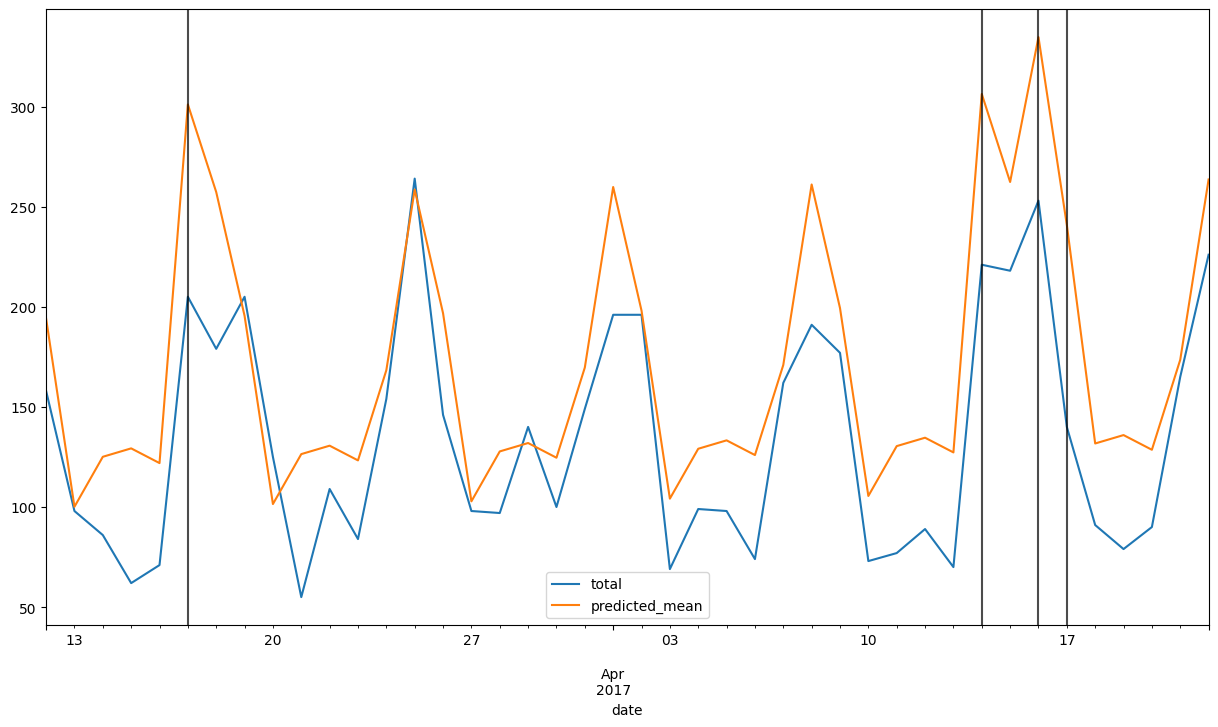

In [79]:
ax = test['total'].plot(legend=True, figsize=(15,8))
predictions.plot(legend=True)

for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='black', alpha = 0.7);  # add a semi-transparent grey line

In [80]:
rmse(test['total'], predictions)

48.017494749636754

In [81]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

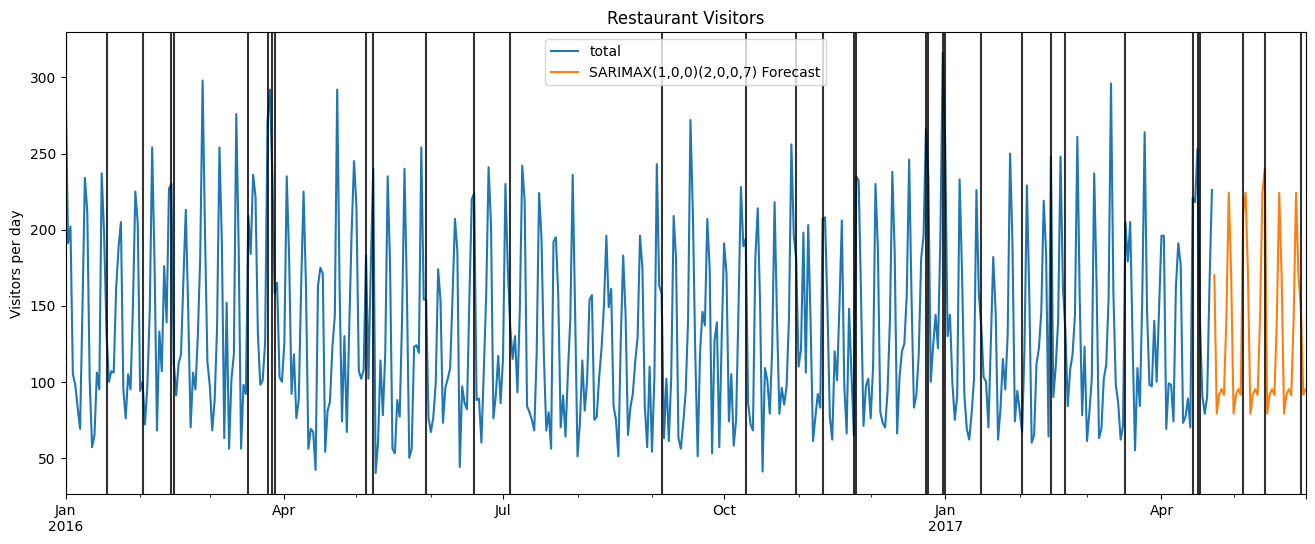

In [83]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.8);